# Replicating Maliar, Maliar, and Valli (2010, JEDC) to solve Krusell and Smith (1998, JPE) model using Julia


By [Shunsuke Hori](https://github.com/Shunsuke-Hori)


# Overview of the notebook
This notebook solves the model of [Krusell and Smith (1998, JPE)](https://www.journals.uchicago.edu/doi/10.1086/250034) and succesfully replicating the result of [Maliar, Maliar, and Valli (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001328).

The solution strategy is as follows

1. Solve the individual problem by Euler equation method or value function iteration (VFI) with 2D interpolation
    - Agents are boundedly rational. In the code, they take into account the information about the mean of capital
    - Aggregate law of motion is approximated by log-linear relation, i.e. $\log(K_{t+1})=B1+B2\log(K_{t})$ for good aggregate state and $\log(K_{t+1})=B3+B4\log(K_{t})$ for bad aggregate state 
    - If specified, Howard's policy iteration is used
1. Compute the path of aggregate capital using the policy function obtained by 1. There are two ways of simulation:
    - Monte Carlo following Krusell and Smith (1998). That is, aggregate technology shocks and idiosyncratic employment shocks are drawn for many agents and many periods. Then, using the LLN, the aggregate capital is computed by aggregating all agents for all period.
    - Non-stochastic method following [Young (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001316).
1. Update the coefficient of aggregate capital law of motion, $B1$, $B2$, $B3$ and $B4$, by regression
1. Check convergence of $B1$, $B2$, $B3$ and $B4$

NOTE: Regarding interpolation, Krusell and Smith uses various interpolation scheme depending on the purpose, including polynomial interpolation. Maliar, Maliar, and Valli uses spline interpolation in their paper. This notebook only uses linear interpolation.

This notebook written in Julia solves the model much faster than the code of Maliar et al. (2010) written in Matlab according to [den Haan (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001298), although they are not simply comparable because initial guess, interpolation methods, and running environments are different.

# Code to solve models

First thing to do is importing functions from `KSfunctions.ipynb`.

You can find the notebook in the [QuantEcon repositoy](https://github.com/QuantEcon/krusell_smith_code).

In [1]:
using NBInclude
@nbinclude("KSfunctions.ipynb")
using Plots      # to plot the result
pyplot()

Plots.PyPlotBackend()

## Implementation by Euler method

First, construct a `NamedTuple`, `ksp`, which contains the parameters of the model and `kss` which has initial guess of the solution.

(Grid size inconsistency is also checked, which may return error when exiting result is loaded by `load_value=true`)

In [2]:
# instance of KSParameter
ksp = KSParameter()
# instance of KSSolution
kss = KSSolution(ksp, load_value=false, load_B=false)
if size(kss.k_opt,1) != length(ksp.k_grid)
    error("loaded data is inconsistent with k_size")
end
if size(kss.k_opt,2) != length(ksp.K_grid)
    error("loaded data is inconsistent with K_size")
end

Let's draw the shock for stochastic simulation of aggregate law of motion

In [3]:
# generate shocks
Random.seed!(0) # for reproducability
@time zi_shocks, epsi_shocks =generate_shocks(ksp;
        z_shock_size=1100, population=10000);

  4.371816 seconds (3.21 M allocations: 586.618 MiB, 13.49% gc time)


Now, the following cell solves the model with Euler equation method

In [4]:
# find ALM coefficient
sm = Stochastic(epsi_shocks)
T_discard = 100
@time K_ts = find_ALM_coef!(EulerMethod(),
            sm, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by Euler method:  Time: 0:00:55 (1868 iterations))
simulating aggregate path ...100%|██████████████████████| Time: 0:00:55


difference of ALM coefficient is 0.4274221773419343 and B = [0.427422, 0.883746, 0.376204, 0.894308]
 --- Iteration over ALM coefficient: 2 ---


Solving individual UMP by Euler method:  Time: 0:00:43 (1647 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.028843344069455823 and B = [0.15707, 0.959025, 0.129334, 0.963418]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:07
Solving individual UMP by Euler method:  Time: 0:00:47 (1551 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.041342937742292946 and B = [0.178223, 0.953126, 0.158777, 0.955567]
 --- Iteration over ALM coefficient: 4 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:01:04


Solving individual UMP by Euler method:  Time: 0:01:01 (1588 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.06996789267768677 and B = [0.199395, 0.947364, 0.200063, 0.944539]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:60
Solving individual UMP by Euler method:  Time: 0:00:55 (1764 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.06628745779936746 and B = [0.207026, 0.945232, 0.217373, 0.93987]
 --- Iteration over ALM coefficient: 6 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:58
Solving individual UMP by Euler method:  Time: 0:01:12 (1737 iterations)39m39m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.05213785746280725 and B = [0.20833, 0.944852, 0.22311, 0.938326]
 --- Iteration over ALM coefficient: 7 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:06
Solving individual UMP by Euler method:  Time: 0:00:50 (1696 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.03843445449031102 and B = [0.208156, 0.944876, 0.225048, 0.937793]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:03
Solving individual UMP by Euler method:  Time: 0:00:51 (1534 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.02831557297307452 and B = [0.208861, 0.944707, 0.226459, 0.937451]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:14
Solving individual UMP by Euler method:  Time: 0:00:43 (1533 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.021670646983614678 and B = [0.209468, 0.944556, 0.228309, 0.936976]
 --- Iteration over ALM coefficient: 10 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:44 (1494 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.016275853707469368 and B = [0.210447, 0.944305, 0.229415, 0.936704]
 --- Iteration over ALM coefficient: 11 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:01
Solving individual UMP by Euler method:  Time: 0:00:39 (1448 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.012841776586819648 and B = [0.211201, 0.944113, 0.230864, 0.936334]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:13
Solving individual UMP by Euler method:  Time: 0:00:44 (1407 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.010269611634141418 and B = [0.21191, 0.943931, 0.232144, 0.936005]
 --- Iteration over ALM coefficient: 13 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:38 (1373 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.008213240501219299 and B = [0.212511, 0.943775, 0.233169, 0.935742]
 --- Iteration over ALM coefficient: 14 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:12
Solving individual UMP by Euler method:  Time: 0:00:37 (1363 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006609735127601962 and B = [0.213026, 0.943641, 0.234029, 0.93552]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:34 (1346 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.00534780310036953 and B = [0.213456, 0.943529, 0.23475, 0.935334]
 --- Iteration over ALM coefficient: 16 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:08
Solving individual UMP by Euler method:  Time: 0:00:31 (1326 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.004329206686207454 and B = [0.213807, 0.943437, 0.235336, 0.935182]
 --- Iteration over ALM coefficient: 17 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:49


Solving individual UMP by Euler method:  Time: 0:00:30 (1302 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.0035004966397757242 and B = [0.214094, 0.943362, 0.235806, 0.93506]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:29 (1274 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.002828208266825921 and B = [0.214326, 0.943301, 0.236184, 0.934962]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:29 (1245 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.002284039023221912 and B = [0.214513, 0.943252, 0.236488, 0.934883]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:28 (1215 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0018437298560852189 and B = [0.214664, 0.943212, 0.236733, 0.934819]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:28 (1185 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.0014875367781911342 and B = [0.214785, 0.943181, 0.23693, 0.934768]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:27 (1153 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.001199397336297564 and B = [0.214882, 0.943155, 0.237088, 0.934727]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:26 (1120 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0009664365422264176 and B = [0.214959, 0.943135, 0.237215, 0.934693]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:25 (1086 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0007782211236908587 and B = [0.215022, 0.943118, 0.237317, 0.934667]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by Euler method:  Time: 0:00:24 (1052 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0006262672114309698 and B = [0.215072, 0.943105, 0.237398, 0.934646]
 --- Iteration over ALM coefficient: 26 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:24 (1018 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0005036806252466108 and B = [0.215111, 0.943095, 0.237464, 0.934629]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:23 (983 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.0004048630187176161 and B = [0.215143, 0.943086, 0.237516, 0.934615]
 --- Iteration over ALM coefficient: 28 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:24 (948 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00032526597520710077 and B = [0.215169, 0.94308, 0.237558, 0.934604]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:21 (912 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0002611957252989794 and B = [0.215189, 0.943074, 0.237591, 0.934596]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:20 (877 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00020965641348305586 and B = [0.215206, 0.94307, 0.237618, 0.934589]
 --- Iteration over ALM coefficient: 31 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:20 (841 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.00016822346227868268 and B = [0.215219, 0.943067, 0.23764, 0.934583]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48


 --- Iteration over ALM coefficient: 32 ---


Solving individual UMP by Euler method:  Time: 0:00:19 (805 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0001349326456415445 and B = [0.215229, 0.943064, 0.237657, 0.934579]
 --- Iteration over ALM coefficient: 33 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:18 (769 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00010819727466199192 and B = [0.215237, 0.943062, 0.23767, 0.934575]
 --- Iteration over ALM coefficient: 34 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:17 (733 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 8.673613605800212e-5 and B = [0.215244, 0.94306, 0.237681, 0.934572]
 --- Iteration over ALM coefficient: 35 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:16 (696 iterations))m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 6.951508037367216e-5 and B = [0.215249, 0.943058, 0.23769, 0.93457]
 --- Iteration over ALM coefficient: 36 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:15 (660 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.5701457714579794e-5 and B = [0.215254, 0.943057, 0.237697, 0.934568]
 --- Iteration over ALM coefficient: 37 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:15 (624 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.4624363950307444e-5 and B = [0.215257, 0.943056, 0.237703, 0.934566]
 --- Iteration over ALM coefficient: 38 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:14 (588 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.5744114518398984e-5 and B = [0.21526, 0.943056, 0.237707, 0.934565]
 --- Iteration over ALM coefficient: 39 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:13 (551 iterations))m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.862654488913763e-5 and B = [0.215262, 0.943055, 0.237711, 0.934564]
 --- Iteration over ALM coefficient: 40 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:12 (515 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.2923133692759334e-5 and B = [0.215264, 0.943055, 0.237714, 0.934564]
 --- Iteration over ALM coefficient: 41 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:12 (479 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.8353550593069867e-5 and B = [0.215265, 0.943054, 0.237716, 0.934563]
 --- Iteration over ALM coefficient: 42 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:49


Solving individual UMP by Euler method:  Time: 0:00:10 (444 iterations))m
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.4693034674578831e-5 and B = [0.215266, 0.943054, 0.237718, 0.934563]
 --- Iteration over ALM coefficient: 43 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:10 (409 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.1760917077247024e-5 and B = [0.215267, 0.943054, 0.23772, 0.934562]
 --- Iteration over ALM coefficient: 44 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:09 (375 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 9.41266795084772e-6 and B = [0.215268, 0.943054, 0.237721, 0.934562]
 --- Iteration over ALM coefficient: 45 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:08 (341 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 7.531988979042614e-6 and B = [0.215269, 0.943053, 0.237722, 0.934562]
 --- Iteration over ALM coefficient: 46 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:07 (309 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.026056971419891e-6 and B = [0.215269, 0.943053, 0.237722, 0.934561]
 --- Iteration over ALM coefficient: 47 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:07 (277 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.819921083698553e-6 and B = [0.215269, 0.943053, 0.237723, 0.934561]
 --- Iteration over ALM coefficient: 48 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:06 (247 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.854311318690629e-6 and B = [0.21527, 0.943053, 0.237723, 0.934561]
 --- Iteration over ALM coefficient: 49 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:05 (219 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.081266870652577e-6 and B = [0.21527, 0.943053, 0.237724, 0.934561]
 --- Iteration over ALM coefficient: 50 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:04 (192 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.462191460161911e-6 and B = [0.21527, 0.943053, 0.237724, 0.934561]
 --- Iteration over ALM coefficient: 51 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:04 (166 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.966297479089052e-6 and B = [0.21527, 0.943053, 0.237724, 0.934561]
 --- Iteration over ALM coefficient: 52 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:03 (145 iterations))m
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.570472841799786e-6 and B = [0.21527, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 53 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


Solving individual UMP by Euler method:  Time: 0:00:03 (128 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.255154174845119e-6 and B = [0.21527, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 54 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:49


Solving individual UMP by Euler method:  Time: 0:00:03 (112 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.0031489979522856e-6 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 55 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:02 (98 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 8.021311037054168e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 56 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:02 (83 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.403482372685509e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 57 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:02 (70 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 5.110198040003677e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 58 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:01 (60 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.084398875503492e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 59 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:01 (50 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.260620214939891e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 60 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:01 (43 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.6115551851613183e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 61 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:01 (38 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.1025903501614707e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 62 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:01 (34 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.702155499050395e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 63 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:01 (30 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.3810777033107513e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 64 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:49


Solving individual UMP by Euler method:  Time: 0:00:01 (26 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.1216127535074172e-7 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 65 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:01 (23 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 9.148415422433054e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 66 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (20 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 7.473471297370082e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 67 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (18 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.143499040045519e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 68 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:00 (15 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 5.0193278477994596e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 69 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (13 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.117671534298317e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 70 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (12 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.413779550709428e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 71 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (10 iterations)08)
simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


difference of ALM coefficient is 2.8150770658985635e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 72 ---


Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)-08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.343277544225586e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 73 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)-08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.9557704206141224e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 74 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by Euler method:  Time: 0:00:00 (7 iterations)-08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.6267515168255642e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 75 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.3595495645946087e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 76 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.1200876531836101e-8 and B = [0.215271, 0.943053, 0.237725, 0.934561]
 --- Iteration over ALM coefficient: 77 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 9.58133941630912e-9 and B = [0.215271, 0.943053, 0.237725, 0.934561]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 9.58133941630912e-9
-----------------------------------------------------
5339.440033 seconds (32.53 G allocations: 4.137 TiB, 13.16% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


Let's compare the true aggreate law of motion for capital and approximated one with figure and regression

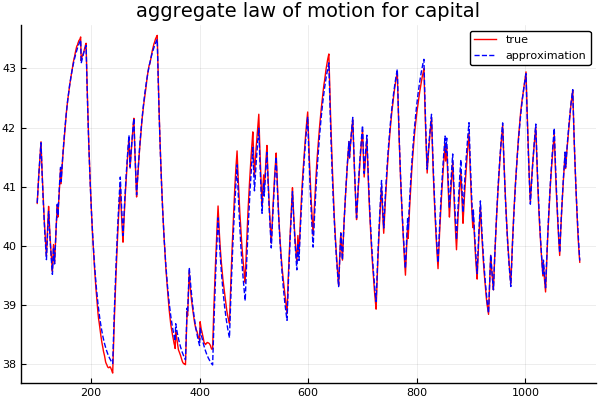

In [5]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B,K_ts, T_discard = T_discard)

In [6]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.2152708351122895+0.9430528182384078log(K_{t}) in good time (R2 = 0.9999151237266661)
log(K_{t+1})=0.23772541215883886+0.9345606235869293log(K_{t}) in bad time (R2 = 0.999832712029906)


The approximated law of motion of capital is very close to the true one, which implies that assuming agents are partially rational is not bad idea since the difference of their actions are negligible.

The mean of capital, about 40, is  sufficiently close to Maliar et al. (2010).

In [7]:
@save "result_Euler.jld2" ksp kss 

In [8]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.transmat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 40.70988915828525
mean of capital implied by simulation is 40.735349390944755


## Figures in Krusell-Smith

Now, plot the replication figure:

### Figure 1

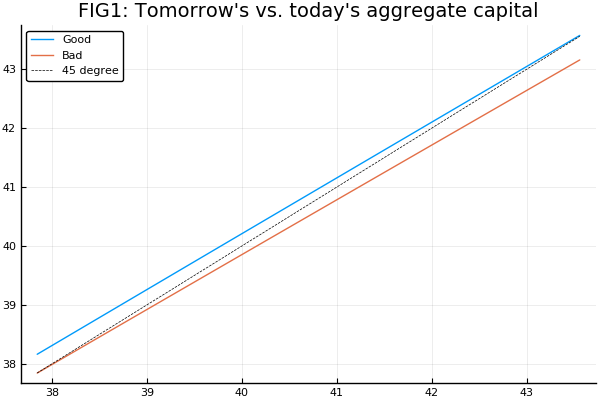

In [9]:
plot_Fig1(ksp ,kss, K_ts)

### Figure 2

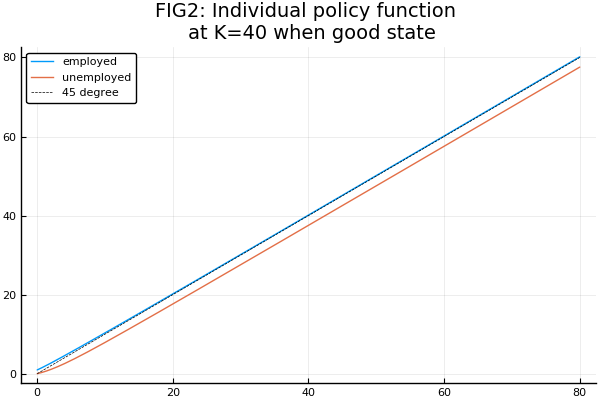

In [10]:
plot_Fig2(ksp, kss, 40)

Both figures are replicated well. 

# Solution with Young (2008)'s method
In this section, aggregate capital is simulated by the method of Young (2008).

In [11]:
kss = KSSolution(ksp, load_value=false, load_B=false)
ns = NonStochastic(ksp, zi_shocks[1])
@time K_ts = find_ALM_coef!(EulerMethod(), 
            ns, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by Euler method:  Time: 0:00:42 (1868 iterations))
simulating aggregate path ... 90%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 0.4561348316213136 and B = [0.456135, 0.877212, 0.436797, 0.880838]
 --- Iteration over ALM coefficient: 2 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:44 (2006 iterations))
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.008617043773197455 and B = [0.142877, 0.962002, 0.122422, 0.966001]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:30 (1375 iterations))
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.007375020667367477 and B = [0.146027, 0.961212, 0.128755, 0.964392]
 --- Iteration over ALM coefficient: 4 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:32 (1464 iterations))
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.005267484488800378 and B = [0.146131, 0.961154, 0.129092, 0.9643]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:29 (1345 iterations))
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.0040070314216140435 and B = [0.146451, 0.961065, 0.130024, 0.964064]
 --- Iteration over ALM coefficient: 6 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:29 (1329 iterations))
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.002959894299560145 and B = [0.146606, 0.961018, 0.130712, 0.963886]
 --- Iteration over ALM coefficient: 7 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:27 (1278 iterations))
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.002149672093765459 and B = [0.146684, 0.960994, 0.131256, 0.963744]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:26 (1228 iterations))
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.001557972215212089 and B = [0.146711, 0.960985, 0.131645, 0.963643]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:25 (1176 iterations))
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.0013627235518748892 and B = [0.146715, 0.960982, 0.131917, 0.963572]
 --- Iteration over ALM coefficient: 10 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:24 (1124 iterations))
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.0011429971537960382 and B = [0.146711, 0.960983, 0.132106, 0.963522]
 --- Iteration over ALM coefficient: 11 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:23 (1075 iterations))
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.000933283892693676 and B = [0.146706, 0.960983, 0.132239, 0.963487]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:22 (1028 iterations))
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.0007498547904362107 and B = [0.146704, 0.960984, 0.132336, 0.963462]
 --- Iteration over ALM coefficient: 13 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:22 (985 iterations)8)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 0.0005976751652848611 and B = [0.146705, 0.960983, 0.132409, 0.963443]
 --- Iteration over ALM coefficient: 14 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:21 (947 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0004756173132779984 and B = [0.146711, 0.960982, 0.132466, 0.963428]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:20 (912 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.00037978251670364727 and B = [0.146718, 0.96098, 0.132513, 0.963416]
 --- Iteration over ALM coefficient: 16 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:19 (880 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.0003054532672387422 and B = [0.146728, 0.960977, 0.132552, 0.963406]
 --- Iteration over ALM coefficient: 17 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:18 (852 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.00024810888217277616 and B = [0.146738, 0.960974, 0.132587, 0.963397]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:18 (827 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.000203855571243583 and B = [0.146748, 0.960972, 0.132617, 0.963389]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:17 (804 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.00016953933124272402 and B = [0.146759, 0.960969, 0.132644, 0.963382]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:17 (782 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.00014270299955676524 and B = [0.146768, 0.960966, 0.132668, 0.963375]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (762 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.00012147997353278983 and B = [0.146778, 0.960964, 0.132689, 0.96337]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (744 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.00010447742525301895 and B = [0.146786, 0.960962, 0.132709, 0.963365]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (725 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 9.066849963249024e-5 and B = [0.146794, 0.96096, 0.132726, 0.96336]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:15 (708 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 7.929176853394004e-5 and B = [0.146802, 0.960958, 0.132742, 0.963356]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:15 (691 iterations)8)
simulating aggregate path ... 87%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 6.97903851978876e-5 and B = [0.146809, 0.960956, 0.132756, 0.963352]
 --- Iteration over ALM coefficient: 26 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (674 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.175582296052973e-5 and B = [0.146815, 0.960954, 0.132769, 0.963349]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (658 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.488468390446588e-5 and B = [0.14682, 0.960953, 0.132781, 0.963346]
 --- Iteration over ALM coefficient: 28 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (642 iterations))m
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.89512334236053e-5 and B = [0.146825, 0.960952, 0.132792, 0.963343]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (626 iterations)8)
simulating aggregate path ... 94%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 4.37845498754974e-5 and B = [0.14683, 0.960951, 0.132801, 0.96334]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:15 (610 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 3.92541615132358e-5 and B = [0.146834, 0.960949, 0.13281, 0.963338]
 --- Iteration over ALM coefficient: 31 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (595 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.5258409811500524e-5 and B = [0.146838, 0.960948, 0.132817, 0.963336]
 --- Iteration over ALM coefficient: 32 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:13 (579 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.1717546197990165e-5 and B = [0.146841, 0.960948, 0.132824, 0.963334]
 --- Iteration over ALM coefficient: 33 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (564 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.8567378619087647e-5 and B = [0.146844, 0.960947, 0.132831, 0.963333]
 --- Iteration over ALM coefficient: 34 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (548 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.5756294767614873e-5 and B = [0.146847, 0.960946, 0.132837, 0.963331]
 --- Iteration over ALM coefficient: 35 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (533 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.3240819451986194e-5 and B = [0.14685, 0.960945, 0.132842, 0.96333]
 --- Iteration over ALM coefficient: 36 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:11 (518 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.0985733613115842e-5 and B = [0.146852, 0.960945, 0.132847, 0.963329]
 --- Iteration over ALM coefficient: 37 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:11 (503 iterations))m
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.896030110459801e-5 and B = [0.146854, 0.960944, 0.132851, 0.963327]
 --- Iteration over ALM coefficient: 38 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:11 (488 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.713855817897514e-5 and B = [0.146856, 0.960944, 0.132855, 0.963326]
 --- Iteration over ALM coefficient: 39 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:10 (473 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 1.5498205413494448e-5 and B = [0.146858, 0.960943, 0.132858, 0.963325]
 --- Iteration over ALM coefficient: 40 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:10 (458 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.4019786232499776e-5 and B = [0.146859, 0.960943, 0.132861, 0.963325]
 --- Iteration over ALM coefficient: 41 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:10 (443 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.2686044406962083e-5 and B = [0.146861, 0.960943, 0.132864, 0.963324]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


 --- Iteration over ALM coefficient: 42 ---


Solving individual UMP by Euler method:  Time: 0:00:09 (429 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1481971272403468e-5 and B = [0.146862, 0.960942, 0.132867, 0.963323]
 --- Iteration over ALM coefficient: 43 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:09 (414 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.0394878791397666e-5 and B = [0.146863, 0.960942, 0.132869, 0.963323]
 --- Iteration over ALM coefficient: 44 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:09 (400 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 9.412208783921017e-6 and B = [0.146864, 0.960942, 0.132871, 0.963322]
 --- Iteration over ALM coefficient: 45 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (385 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.523977039931463e-6 and B = [0.146865, 0.960941, 0.132873, 0.963322]
 --- Iteration over ALM coefficient: 46 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (371 iterations)8)
simulating aggregate path ... 71%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 7.72064266219008e-6 and B = [0.146866, 0.960941, 0.132875, 0.963321]
 --- Iteration over ALM coefficient: 47 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (357 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.994028114354345e-6 and B = [0.146867, 0.960941, 0.132877, 0.963321]
 --- Iteration over ALM coefficient: 48 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (344 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.336323091604701e-6 and B = [0.146867, 0.960941, 0.132878, 0.96332]
 --- Iteration over ALM coefficient: 49 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (330 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.741289606842059e-6 and B = [0.146868, 0.960941, 0.132879, 0.96332]
 --- Iteration over ALM coefficient: 50 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (316 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.20255477609588e-6 and B = [0.146869, 0.96094, 0.132881, 0.96332]
 --- Iteration over ALM coefficient: 51 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (303 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.714489223428542e-6 and B = [0.146869, 0.96094, 0.132882, 0.963319]
 --- Iteration over ALM coefficient: 52 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (290 iterations))m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.272670644511756e-6 and B = [0.14687, 0.96094, 0.132883, 0.963319]
 --- Iteration over ALM coefficient: 53 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (277 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.8725663447647385e-6 and B = [0.14687, 0.96094, 0.132883, 0.963319]
 --- Iteration over ALM coefficient: 54 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (264 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.5099821105444295e-6 and B = [0.14687, 0.96094, 0.132884, 0.963319]
 --- Iteration over ALM coefficient: 55 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (252 iterations)8)
simulating aggregate path ... 93%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 3.1813702160432555e-6 and B = [0.146871, 0.96094, 0.132885, 0.963318]
 --- Iteration over ALM coefficient: 56 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (239 iterations)8)


difference of ALM coefficient is 2.884014287607428e-6 and B = [0.146871, 0.96094, 0.132886, 0.963318]
 --- Iteration over ALM coefficient: 57 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (228 iterations)8)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.613897075925964e-6 and B = [0.146871, 0.96094, 0.132886, 0.963318]
 --- Iteration over ALM coefficient: 58 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (216 iterations)8)
simulating aggregate path ... 94%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 2.3698285921691653e-6 and B = [0.146872, 0.96094, 0.132887, 0.963318]
 --- Iteration over ALM coefficient: 59 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (204 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.1483925622678424e-6 and B = [0.146872, 0.96094, 0.132887, 0.963318]
 --- Iteration over ALM coefficient: 60 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (193 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.947404442897982e-6 and B = [0.146872, 0.96094, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 61 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (182 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.7653895722224977e-6 and B = [0.146872, 0.96094, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 62 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (172 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.6003569559552844e-6 and B = [0.146873, 0.960939, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 63 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (161 iterations)8)
simulating aggregate path ... 95%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 1.4512411514178147e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]
 --- Iteration over ALM coefficient: 64 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (151 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.3154069426757342e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


 --- Iteration over ALM coefficient: 65 ---


Solving individual UMP by Euler method:  Time: 0:00:03 (142 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1924123506645845e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]
 --- Iteration over ALM coefficient: 66 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (132 iterations))m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.0814044617279972e-6 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 67 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (123 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 9.802967592675849e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 68 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (115 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 8.885985442186328e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 69 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (106 iterations)8)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.059627235879052e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 70 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (98 iterations)08)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 7.306925396410868e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 71 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (91 iterations)08)
simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


difference of ALM coefficient is 6.623617018197692e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 72 ---


Solving individual UMP by Euler method:  Time: 0:00:02 (83 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.010190553018546e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 73 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (77 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.445665013925627e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 74 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (70 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.942435950783253e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 75 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (65 iterations)8)m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.477099435074017e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 76 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:01 (59 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.0644643303777706e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 77 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (55 iterations)08)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.6810898323969e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 78 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (50 iterations)08)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.342283573515292e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 79 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (47 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.024636119897117e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 80 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (44 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.7407118780020667e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 81 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (41 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.485447657130102e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 82 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (39 iterations)08)
simulating aggregate path ...100%|██████████████████████| Time: 0:00:02

difference of ALM coefficient is 2.250508124301831e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 83 ---



Solving individual UMP by Euler method:  Time: 0:00:01 (37 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.0398252301156994e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 84 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (35 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.8501803553117036e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 85 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (33 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.6791167115060013e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 86 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (32 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.51750390336991e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 87 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (30 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.3786970365359252e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 88 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (28 iterations)8)m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.2521602682502575e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 89 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (27 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1326223903207477e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 90 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (25 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.0293103455683017e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 91 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (24 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 9.30346010230565e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 92 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (22 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.464245168648965e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 93 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (21 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 7.652786657152966e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 94 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (19 iterations)8)m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.974838753781576e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 95 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (19 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.263902901926244e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 96 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (17 iterations)8)m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.709994851943456e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 97 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (16 iterations)8)m
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.174000020091718e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 98 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (15 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.6844407131096943e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 99 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (14 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.254244148627073e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 100 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (14 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.804459813849803e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 101 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (12 iterations)08)
simulating aggregate path ... 75%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.4976016666243837e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 102 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (12 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.1486846935324664e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 103 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (10 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.904139495552016e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 104 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (11 iterations)8)m
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.5656462981915595e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 105 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)-08)
simulating aggregate path ... 93%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 2.3675274851697736e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 106 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)-08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.1270876116030735e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 107 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.9416610569367165e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 108 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)-08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.7361788201553097e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 109 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (7 iterations)08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.5907071271303863e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 110 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.468659144299167e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 111 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.318548634166028e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 112 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1777319147698861e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 113 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
simulating aggregate path ... 74%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.078307437785142e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 114 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 9.680553608726328e-9 and B = [0.146874, 0.960939, 0.132892, 0.963317]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 9.680553608726328e-9
-----------------------------------------------------
1207.564574 seconds (7.95 G allocations: 1.278 TiB, 16.40% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


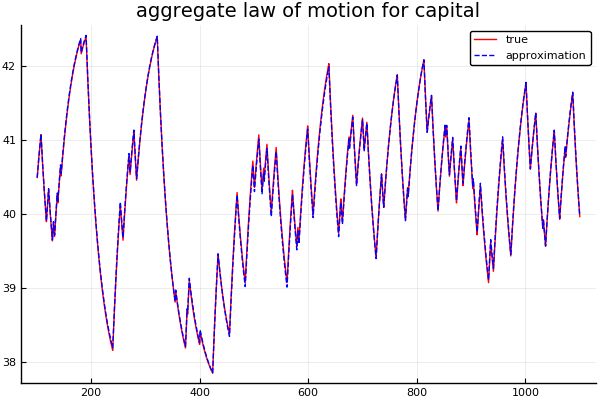

In [12]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B,K_ts, T_discard = T_discard)

In [13]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.1468742297741828+0.9609390142949115log(K_{t}) in good time (R2 = 0.9999985643122742)
log(K_{t+1})=0.1328919612162856+0.9633166115209159log(K_{t}) in bad time (R2 = 0.9999976186272014)


In [14]:
@save "result_Young.jld2" ksp kss 

In [15]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.transmat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 40.1009518847617
mean of capital implied by simulation is 40.350045260575776


## Figures in Krusell-Smith

### Figure 1

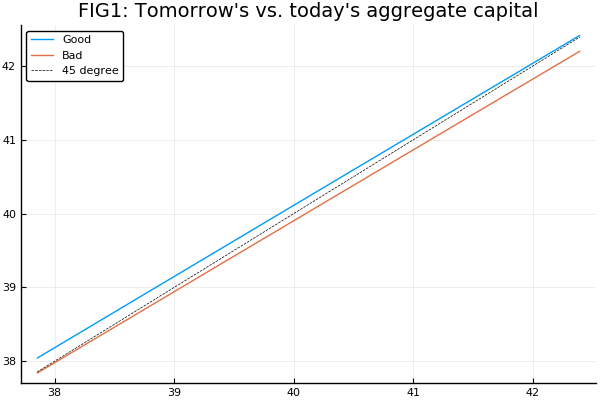

In [16]:
plot_Fig1(ksp ,kss, K_ts)

### Figure 2

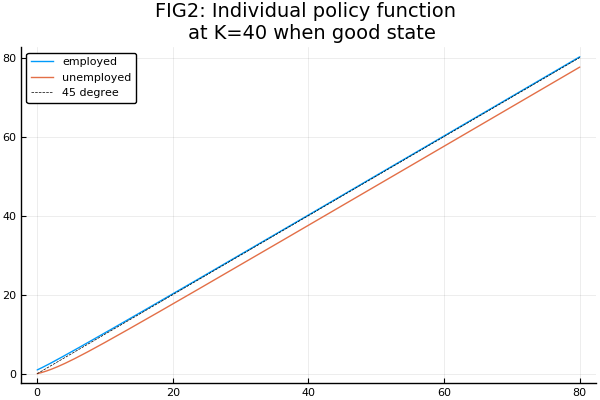

In [17]:
plot_Fig2(ksp, kss, 40)

# Solution with value function iteration
In this section, each agent's utility maximization problem is solved by value function iteration.

## Implementation

Let's skip the following steps in this section to save computational time.
- consturuction of `ksp` instance since it is same
- consturuction of `kss` instance to use the previous result as initial guess of the solution
- draws of the shocks to use same ones

However, instead of constructing `kss` again, obtain value from the policy function derived by Euler method:

In [18]:
iterate_policy!(ksp, kss, n_iter=30)

In [19]:
kss = KSSolution(ksp, load_value=false, load_B=false)
sm = Stochastic(epsi_shocks)
@time K_ts = find_ALM_coef!(VFI(Howard_on=false, Howard_n_iter=20),
                sm, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0106e-08)m

 ** VFI converged successfully!! dif = 9.994721494877012e-9

Solving individual UMP by VFI:  Time: 0:07:40 (1736 iterations)


simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.40981915138048663 and B = [0.409819, 0.888428, 0.368112, 0.89638]
 --- Iteration over ALM coefficient: 2 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:44
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.08644e-08)

 ** VFI converged successfully!! dif = 9.904965736495797e-9


Solving individual UMP by VFI:  Time: 0:05:01 (1108 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.03495835157554017 and B = [0.157904, 0.958425, 0.132341, 0.962185]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00421e-08)

 ** VFI converged successfully!! dif = 9.930090527632274e-9


Solving individual UMP by VFI:  Time: 0:06:01 (1277 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.026634144848466434 and B = [0.160067, 0.957645, 0.135854, 0.961176]
 --- Iteration over ALM coefficient: 4 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00639e-08)

 ** VFI converged successfully!! dif = 9.951378387995646e-9


Solving individual UMP by VFI:  Time: 0:05:37 (1188 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.019552565786627618 and B = [0.160386, 0.957552, 0.142213, 0.959529]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0029e-08)m

 ** VFI converged successfully!! dif = 9.916846011037705e-9


Solving individual UMP by VFI:  Time: 0:05:32 (1191 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.018866280640597838 and B = [0.160475, 0.957502, 0.147392, 0.958155]
 --- Iteration over ALM coefficient: 6 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:51


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00088e-08)

 ** VFI converged successfully!! dif = 9.89672344076098e-9


Solving individual UMP by VFI:  Time: 0:06:51 (1168 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.018469934775198232 and B = [0.160952, 0.957356, 0.152656, 0.956749]
 --- Iteration over ALM coefficient: 7 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:10
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00861e-08)

 ** VFI converged successfully!! dif = 9.973092574000475e-9


Solving individual UMP by VFI:  Time: 0:09:01 (1148 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.01747340857386273 and B = [0.161412, 0.957213, 0.1572, 0.955522]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:10
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0438e-08)m

 ** VFI converged successfully!! dif = 9.973575743060792e-9


Solving individual UMP by VFI:  Time: 0:07:37 (1120 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.014772867543207613 and B = [0.161526, 0.957171, 0.159742, 0.954836]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:17
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00105e-08)

 ** VFI converged successfully!! dif = 9.898343478198512e-9


Solving individual UMP by VFI:  Time: 0:07:11 (1090 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.0119686235844767 and B = [0.161739, 0.957109, 0.161369, 0.954403]
 --- Iteration over ALM coefficient: 10 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:49


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00715e-08)

 ** VFI converged successfully!! dif = 9.958569080481539e-9


Solving individual UMP by VFI:  Time: 0:05:60 (1071 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.010121165937028664 and B = [0.162186, 0.956985, 0.163113, 0.953937]
 --- Iteration over ALM coefficient: 11 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:54
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00076e-08)

 ** VFI converged successfully!! dif = 9.895472885546042e-9


Solving individual UMP by VFI:  Time: 0:06:08 (1052 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.008522055110732618 and B = [0.1625, 0.956897, 0.16455, 0.95355]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:07
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00516e-08)

 ** VFI converged successfully!! dif = 9.938872835846269e-9


Solving individual UMP by VFI:  Time: 0:06:28 (1032 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006873030896342114 and B = [0.162721, 0.956834, 0.165457, 0.953305]
 --- Iteration over ALM coefficient: 13 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:10
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00505e-08)

 ** VFI converged successfully!! dif = 9.937792810887913e-9


Solving individual UMP by VFI:  Time: 0:04:33 (1005 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.005497245600604689 and B = [0.16287, 0.956791, 0.166143, 0.953119]
 --- Iteration over ALM coefficient: 14 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:00
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00345e-08)

 ** VFI converged successfully!! dif = 9.921933497025748e-9


Solving individual UMP by VFI:  Time: 0:04:52 (980 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00434544318399982 and B = [0.162991, 0.956758, 0.166641, 0.952986]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.05041e-08)

 ** VFI converged successfully!! dif = 9.795201094675576e-9


Solving individual UMP by VFI:  Time: 0:04:48 (962 iterations)


difference of ALM coefficient is 0.0034499882739223164 and B = [0.163139, 0.956718, 0.167049, 0.952877]
 --- Iteration over ALM coefficient: 16 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00627e-08)

 ** VFI converged successfully!! dif = 9.949815193976974e-9


Solving individual UMP by VFI:  Time: 0:04:22 (947 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.002802292303733439 and B = [0.163272, 0.956681, 0.167436, 0.952774]
 --- Iteration over ALM coefficient: 17 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00748e-08)

 ** VFI converged successfully!! dif = 9.961780733647174e-9


Solving individual UMP by VFI:  Time: 0:04:17 (929 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.002263609523039556 and B = [0.163375, 0.956652, 0.167738, 0.952692]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00016e-08)

 ** VFI converged successfully!! dif = 9.889419061437366e-9


Solving individual UMP by VFI:  Time: 0:04:15 (909 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.001817939107580796 and B = [0.16345, 0.956632, 0.167972, 0.952629]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:60
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00206e-08)

 ** VFI converged successfully!! dif = 9.908148967952002e-9


Solving individual UMP by VFI:  Time: 0:04:20 (886 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.001447015535256918 and B = [0.163501, 0.956617, 0.168146, 0.952582]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.05623e-08)

 ** VFI converged successfully!! dif = 9.79409264800779e-9


Solving individual UMP by VFI:  Time: 0:04:06 (862 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0011372344407999113 and B = [0.163534, 0.956608, 0.168271, 0.952548]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00682e-08)

 ** VFI converged successfully!! dif = 9.95518689705932e-9


Solving individual UMP by VFI:  Time: 0:03:46 (834 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0008842934979758355 and B = [0.163555, 0.956602, 0.168359, 0.952524]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.09122e-08)

 ** VFI converged successfully!! dif = 9.909769005389535e-9


Solving individual UMP by VFI:  Time: 0:03:40 (803 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.000674766024827439 and B = [0.16356, 0.9566, 0.168415, 0.952509]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:54
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00112e-08)

 ** VFI converged successfully!! dif = 9.898798225549399e-9


Solving individual UMP by VFI:  Time: 0:04:32 (775 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.0005106194139591347 and B = [0.163563, 0.9566, 0.168453, 0.952499]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00563e-08)

 ** VFI converged successfully!! dif = 9.943363465936272e-9


Solving individual UMP by VFI:  Time: 0:03:56 (747 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0003846782282793948 and B = [0.163565, 0.956599, 0.16848, 0.952492]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00062e-08)

 ** VFI converged successfully!! dif = 9.893796004689648e-9


Solving individual UMP by VFI:  Time: 0:03:26 (720 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0002888812961046039 and B = [0.163566, 0.956599, 0.1685, 0.952486]
 --- Iteration over ALM coefficient: 26 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:58
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01011e-08)

 ** VFI converged successfully!! dif = 9.987587645809981e-9


Solving individual UMP by VFI:  Time: 0:03:20 (692 iterations)


difference of ALM coefficient is 0.00021643666432391573 and B = [0.163567, 0.956599, 0.168514, 0.952482]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01056e-08)

 ** VFI converged successfully!! dif = 9.991936167352833e-9

Solving individual UMP by VFI:  Time: 0:02:59 (665 iterations)


simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0001618659953891155 and B = [0.163567, 0.956598, 0.168524, 0.95248]
 --- Iteration over ALM coefficient: 28 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0001e-08)m

 ** VFI converged successfully!! dif = 9.888594831863884e-9


Solving individual UMP by VFI:  Time: 0:02:49 (639 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00012089161058800868 and B = [0.163567, 0.956598, 0.168532, 0.952478]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00253e-08)

 ** VFI converged successfully!! dif = 9.912412224366562e-9


Solving individual UMP by VFI:  Time: 0:02:44 (612 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 9.022288681753698e-5 and B = [0.163567, 0.956598, 0.168537, 0.952476]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00806e-08)

 ** VFI converged successfully!! dif = 9.967209280148381e-9


Solving individual UMP by VFI:  Time: 0:02:46 (585 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 6.736765290665803e-5 and B = [0.163568, 0.956598, 0.168542, 0.952475]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


 --- Iteration over ALM coefficient: 31 ---


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00151e-08)

 ** VFI converged successfully!! dif = 9.90237936093763e-9


Solving individual UMP by VFI:  Time: 0:02:27 (559 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.021474791880309e-5 and B = [0.163568, 0.956598, 0.168545, 0.952474]
 --- Iteration over ALM coefficient: 32 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01075e-08)

 ** VFI converged successfully!! dif = 9.993783578465809e-9


Solving individual UMP by VFI:  Time: 0:02:20 (532 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.742629943176423e-5 and B = [0.163568, 0.956598, 0.168547, 0.952474]
 --- Iteration over ALM coefficient: 33 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00571e-08)

 ** VFI converged successfully!! dif = 9.94387505670602e-9


Solving individual UMP by VFI:  Time: 0:02:22 (506 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.7849838421550865e-5 and B = [0.163568, 0.956598, 0.168549, 0.952473]
 --- Iteration over ALM coefficient: 34 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:60
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.18309e-08)

 ** VFI converged successfully!! dif = 9.914003840094665e-9


Solving individual UMP by VFI:  Time: 0:02:16 (480 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.06760543511042e-5 and B = [0.163568, 0.956598, 0.16855, 0.952473]
 --- Iteration over ALM coefficient: 35 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00188e-08)

 ** VFI converged successfully!! dif = 9.90593207461643e-9


Solving individual UMP by VFI:  Time: 0:02:06 (454 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.548831099887349e-5 and B = [0.163568, 0.956598, 0.168551, 0.952472]
 --- Iteration over ALM coefficient: 36 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00035e-08)

 ** VFI converged successfully!! dif = 9.890754881780595e-9

Solving individual UMP by VFI:  Time: 0:02:02 (428 iterations)


simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.1489728392627407e-5 and B = [0.163568, 0.956598, 0.168551, 0.952472]
 --- Iteration over ALM coefficient: 37 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01666e-08)

 ** VFI converged successfully!! dif = 9.998188943427522e-9


Solving individual UMP by VFI:  Time: 0:01:47 (401 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 8.54165943242613e-6 and B = [0.163568, 0.956598, 0.168552, 0.952472]
 --- Iteration over ALM coefficient: 38 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01127e-08)

 ** VFI converged successfully!! dif = 9.998615269068978e-9


Solving individual UMP by VFI:  Time: 0:01:38 (375 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.390070626305366e-6 and B = [0.163568, 0.956598, 0.168552, 0.952472]
 --- Iteration over ALM coefficient: 39 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00221e-08)

 ** VFI converged successfully!! dif = 9.909143727782066e-9


Solving individual UMP by VFI:  Time: 0:01:33 (350 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.754735674711297e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 40 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00272e-08)

 ** VFI converged successfully!! dif = 9.913833309838083e-9


Solving individual UMP by VFI:  Time: 0:01:33 (325 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.5262605686259274e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 41 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:48


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00666e-08)

 ** VFI converged successfully!! dif = 9.952827895176597e-9


Solving individual UMP by VFI:  Time: 0:01:19 (299 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.6084375954193995e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 42 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01039e-08)

 ** VFI converged successfully!! dif = 9.98960558717954e-9


Solving individual UMP by VFI:  Time: 0:01:12 (272 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.945662049473995e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 43 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00068e-08)

 ** VFI converged successfully!! dif = 9.893682317851926e-9


Solving individual UMP by VFI:  Time: 0:01:06 (250 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.459830877736934e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 44 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00324e-08)

 ** VFI converged successfully!! dif = 9.918636578731821e-9


Solving individual UMP by VFI:  Time: 0:00:59 (226 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.082145164671422e-6 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 45 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00874e-08)

 ** VFI converged successfully!! dif = 9.973206260838197e-9


Solving individual UMP by VFI:  Time: 0:00:56 (203 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 8.559059145596404e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 46 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00173e-08)

 ** VFI converged successfully!! dif = 9.903601494443137e-9


Solving individual UMP by VFI:  Time: 0:00:45 (177 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.928801917465254e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 47 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01044e-08)

 ** VFI converged successfully!! dif = 9.989207683247514e-9


Solving individual UMP by VFI:  Time: 0:00:41 (160 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.5856017519274594e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 48 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00582e-08)

 ** VFI converged successfully!! dif = 9.941715006789309e-9


Solving individual UMP by VFI:  Time: 0:00:37 (135 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.0224917219046077e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 49 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00386e-08)

 ** VFI converged successfully!! dif = 9.919830290527898e-9


Solving individual UMP by VFI:  Time: 0:00:30 (114 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.7203723515500933e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 50 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46


 ** VFI converged successfully!! dif = 9.900105624183198e-9


Solving individual UMP by VFI:  Time: 0:00:26 (102 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.3695260301104248e-7 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 51 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00491e-08)

 ** VFI converged successfully!! dif = 9.90877424555947e-9


Solving individual UMP by VFI:  Time: 0:00:23 (91 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.254306560283247e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 52 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:46


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01161e-08)

 ** VFI converged successfully!! dif = 9.996739436246571e-9


Solving individual UMP by VFI:  Time: 0:00:16 (64 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.0716466727900276e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 53 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00586e-08)

 ** VFI converged successfully!! dif = 9.875861906039063e-9


Solving individual UMP by VFI:  Time: 0:00:16 (62 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 8.263041079148437e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 54 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01234e-08)

 ** VFI converged successfully!! dif = 9.930232636179426e-9


Solving individual UMP by VFI:  Time: 0:00:19 (53 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 7.70773453673268e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 55 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00312e-08)

 ** VFI converged successfully!! dif = 9.85389192464936e-9


Solving individual UMP by VFI:  Time: 0:00:11 (37 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.289005560766725e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 56 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01698e-08)

 ** VFI converged successfully!! dif = 9.926424127115752e-9


Solving individual UMP by VFI:  Time: 0:00:12 (44 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.8497884324861786e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 57 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0109e-08)m

 ** VFI converged successfully!! dif = 9.653746246840456e-9


Solving individual UMP by VFI:  Time: 0:00:03 (12 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.1420190931810126e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 58 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00222e-08)

 ** VFI converged successfully!! dif = 9.835076753006433e-9


Solving individual UMP by VFI:  Time: 0:00:04 (14 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.83765389466717e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 59 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01761e-08)

 ** VFI converged successfully!! dif = 9.984773896576371e-9


Solving individual UMP by VFI:  Time: 0:00:19 (29 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.610288508761663e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 60 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00211e-08)

 ** VFI converged successfully!! dif = 9.742166184878442e-9


Solving individual UMP by VFI:  Time: 0:00:09 (32 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.0657723009677156e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 61 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01125e-08)

 ** VFI converged successfully!! dif = 9.302198122895788e-9


Solving individual UMP by VFI:  Time: 0:00:02 (7 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.8210742242240627e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 62 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:49
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02092e-08)

 ** VFI converged successfully!! dif = 9.821661706155282e-9


Solving individual UMP by VFI:  Time: 0:00:04 (16 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.7284448506081915e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 63 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:56
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03412e-08)

 ** VFI converged successfully!! dif = 9.773799547474482e-9


Solving individual UMP by VFI:  Time: 0:00:03 (10 iterations)


difference of ALM coefficient is 2.6827126103912136e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 64 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:55
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02028e-08)

 ** VFI converged successfully!! dif = 9.798043265618617e-9


Solving individual UMP by VFI:  Time: 0:00:09 (23 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.1894435769654876e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 65 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:06
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0246e-08)

 ** VFI converged successfully!! dif = 8.452929023405886e-9


Solving individual UMP by VFI:  Time: 0:00:01 (2 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.481266289129259e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 66 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:10
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0027e-08)m

 ** VFI converged successfully!! dif = 9.654883115217672e-9


Solving individual UMP by VFI:  Time: 0:00:07 (16 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 7.605357332796103e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 67 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:25
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00921e-08)

 ** VFI converged successfully!! dif = 9.494698360867915e-9


Solving individual UMP by VFI:  Time: 0:00:07 (18 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.2512860464729556e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 68 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:08
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03532e-08)

 ** VFI converged successfully!! dif = 9.90937110145751e-9


Solving individual UMP by VFI:  Time: 0:00:04 (9 iterations)


difference of ALM coefficient is 7.537842713900567e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 69 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:09
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.04352e-08)

 ** VFI converged successfully!! dif = 9.676000445324462e-9


Solving individual UMP by VFI:  Time: 0:00:06 (13 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.9365127945647487e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 70 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:38
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.17131e-08)

 ** VFI converged successfully!! dif = 9.706212722448981e-9


Solving individual UMP by VFI:  Time: 0:00:02 (3 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.083794380964733e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 71 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:16
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03949e-08)

 ** VFI converged successfully!! dif = 9.901981457005604e-9


Solving individual UMP by VFI:  Time: 0:00:08 (20 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.1694494246069524e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 72 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:03
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01624e-08)

 ** VFI converged successfully!! dif = 9.609266271581873e-9


Solving individual UMP by VFI:  Time: 0:00:07 (18 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.794263568947855e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 73 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:04
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00909e-08)

 ** VFI converged successfully!! dif = 9.67088453762699e-9


Solving individual UMP by VFI:  Time: 0:00:12 (28 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.303606819187287e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 74 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:05
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.08491e-08)

 ** VFI converged successfully!! dif = 9.860514182946645e-9


Solving individual UMP by VFI:  Time: 0:00:02 (5 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.9473479412335237e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 75 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:55
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.04268e-08)

 ** VFI converged successfully!! dif = 9.954675306289573e-9


Solving individual UMP by VFI:  Time: 0:00:06 (17 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 5.3107950648279e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 76 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:60
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00475e-08)

 ** VFI converged successfully!! dif = 9.630440445107524e-9


Solving individual UMP by VFI:  Time: 0:00:09 (28 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.733898160107607e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 77 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01231e-08)

 ** VFI converged successfully!! dif = 9.615149565433967e-9


Solving individual UMP by VFI:  Time: 0:00:02 (6 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.9481877128766385e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 78 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:55
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0156e-08)m

 ** VFI converged successfully!! dif = 9.544777412884287e-9


Solving individual UMP by VFI:  Time: 0:00:04 (15 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 4.668653294515046e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 79 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:03
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03149e-08)

 ** VFI converged successfully!! dif = 9.762601393958903e-9


Solving individual UMP by VFI:  Time: 0:00:05 (15 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.6328007695909363e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 80 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:56
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.08415e-08)

 ** VFI converged successfully!! dif = 9.012239843286807e-9


Solving individual UMP by VFI:  Time: 0:00:01 (3 iterations)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.0306396659483e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 81 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:05
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.07475e-08)

 ** VFI converged successfully!! dif = 8.433829634668655e-9


Solving individual UMP by VFI:  Time: 0:00:03 (7 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.218024896556315e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 82 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:01
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02466e-08)

 ** VFI converged successfully!! dif = 9.814527857088251e-9


Solving individual UMP by VFI:  Time: 0:00:04 (13 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.475541490189805e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 83 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52


 ** VFI converged successfully!! dif = 9.5682537448738e-9

Solving individual UMP by VFI:  Time: 0:00:06 (21 iterations)


simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 9.932404179679999e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 84 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:58
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.04108e-08)

 ** VFI converged successfully!! dif = 9.927845212587272e-9


Solving individual UMP by VFI:  Time: 0:00:11 (32 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.319129596168757e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 85 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:58
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01126e-08)

 ** VFI converged successfully!! dif = 9.741484063852113e-9


Solving individual UMP by VFI:  Time: 0:00:05 (19 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.0062924091225334e-7 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 86 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02828e-08)

 ** VFI converged successfully!! dif = 9.676256240709336e-9


Solving individual UMP by VFI:  Time: 0:00:07 (29 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.699527898442078e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 87 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:45
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.04966e-08)

 ** VFI converged successfully!! dif = 9.923383004206698e-9


Solving individual UMP by VFI:  Time: 0:00:04 (18 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.4036216766942786e-8 and B = [0.163568, 0.956598, 0.168553, 0.952472]
 --- Iteration over ALM coefficient: 88 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:46
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.04563e-08)

 ** VFI converged successfully!! dif = 9.759219210536685e-9


Solving individual UMP by VFI:  Time: 0:00:03 (11 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.565146086155103e-8 and B = [0.163568, 0.956598, 0.168554, 0.952472]
 --- Iteration over ALM coefficient: 89 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01235e-08)

 ** VFI converged successfully!! dif = 9.646839771448867e-9


Solving individual UMP by VFI:  Time: 0:00:06 (21 iterations)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.199440294452074e-9 and B = [0.163568, 0.956598, 0.168554, 0.952472]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 6.199440294452074e-9
-----------------------------------------------------
15744.605371 seconds (105.99 G allocations: 18.170 TiB, 14.29% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


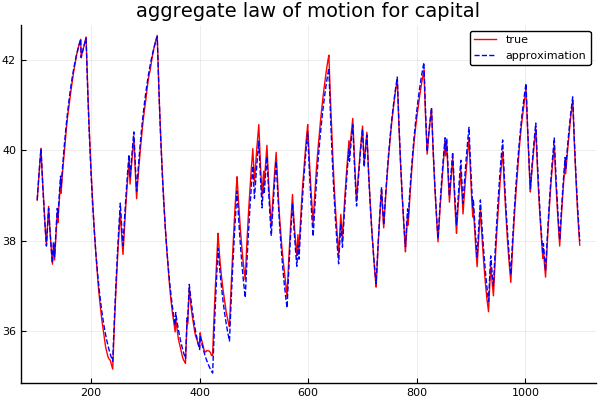

In [20]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B, K_ts, T_discard = T_discard)

In [21]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.16356837879013705+0.9565979669376763log(K_{t}) in good time (R2 = 0.9999370532638105)
log(K_{t+1})=0.16855350739608888+0.952471740243581log(K_{t}) in bad time (R2 = 0.9998794635145657)


In [22]:
@save "result_VFI.jld2" ksp kss 

In [23]:
# Compute mean of capital implied by regression
mc = MarkovChain(ksp.transmat.Pz)
sd = stationary_distributions(mc)[1]
logKg = kss.B[1]/(1-kss.B[2])
logKb = kss.B[3]/(1-kss.B[4])
meanK_reg = exp(sd[1]*logKg + sd[2]*logKb)
meanK_sim = mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 38.765572839077564
mean of capital implied by simulation is 38.882460027956135


## Figures in Krusell-Smith

### Figure 1

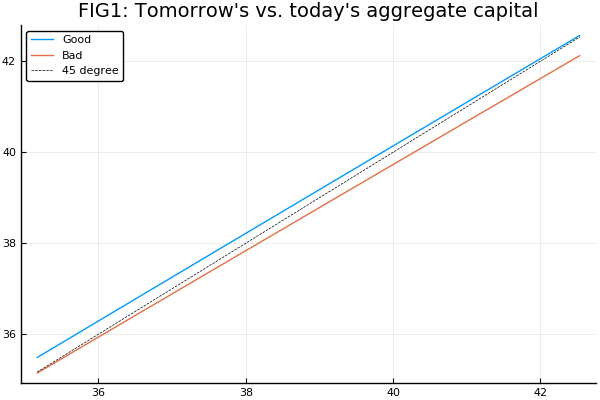

In [24]:
plot_Fig1(ksp, kss, K_ts)

### Figure 2

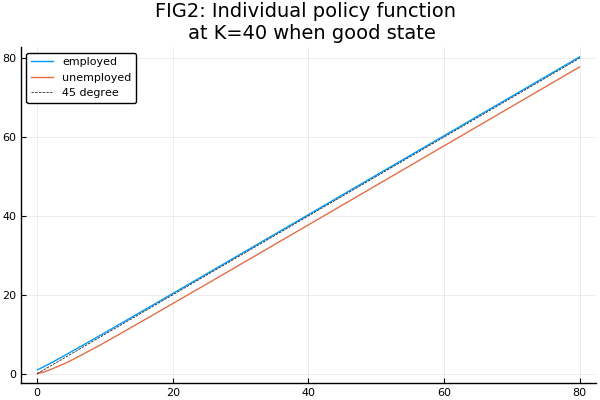

In [25]:
plot_Fig2(ksp, kss, 40)